# Methylation Metaplot

scaled position of genes and features - stetch/shrink individual genes/features to all be the same length, and see if there's a similar distribution of methylation for each treatment combination


**Theoretical pipeline:** (loosely following [Venkataraman et al., 2020](https://github.com/epigeneticstoocean/paper-gonad-meth/blob/master/code/13-DML-Characterization.Rmd))
- scale each gene feature from 0% to 100%
	- calculate gene length (gene.end - gene.start = length)
	- calculate absolute position of CpG (feature.start - gene.start = abs.position)
		- only methylated CpGs? so those with at least 5 sequences? 
		- first plot all 5 replicates (in same color), then can collapse? (so CpG methylated if at least 3/5 replicates have 5 seqs or more)
	- calculate scaled position of CpG in feature/gene (abs.position / geneLength)
- plot histogram/line plot

# 0. load libraries and bed/csv files

In [2]:
library(tidyverse)
library(IRanges)
library(GenomicRanges)

**genomic feature file**

In [7]:
allGenes <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/CV_gene_sorted.bed', sep='\t', header=FALSE)
colnames(allGenes) <- c('chromosome', 'start', 'end')
head(allGenes)

,chromosome,start,end
,<chr>,<int>,<int>
1,NC_035780.1,13578,14594
2,NC_035780.1,28961,33324
3,NC_035780.1,43111,66897
4,NC_035780.1,85606,95254
5,NC_035780.1,99840,106460
6,NC_035780.1,108305,110077


**CpG counts**

already generated this from CpG_coverage script

In [4]:
cpg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/genomic_bed_files/CpG_multicov/all_CpGmulticov.csv')
head(cpg)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC1,HC2,HC3,HC4,HC5,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,NC_035780.1,54,56,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,NC_035780.1,75,77,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,NC_035780.1,93,95,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,NC_035780.1,103,105,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,NC_035780.1,116,118,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,NC_035780.1,134,136,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# 1. Scale the feature
Essentially stretching the feature of interest (gene, exon, intron, UTR) to all be the same length, then plotting the absolute position of methylated CpGs along the feature to look at distribution patterns

### 1a. calculate feature length
(although I end up doing this later in the bigger df)

In [8]:
allGenes$length <- allGenes$end - allGenes$start
colnames(allGenes) <- c('chromosome', 'start', 'stop', 'length')
allGenes$region <- 'gene'
head(allGenes)

,chromosome,start,stop,length,region
,<chr>,<int>,<int>,<int>,<chr>
1,NC_035780.1,13578,14594,1016,gene
2,NC_035780.1,28961,33324,4363,gene
3,NC_035780.1,43111,66897,23786,gene
4,NC_035780.1,85606,95254,9648,gene
5,NC_035780.1,99840,106460,6620,gene
6,NC_035780.1,108305,110077,1772,gene


**add 1KB upstream and downstream**

In [9]:
# calculate 1kb upstream and downstream
allGenes$kb_upstream <- allGenes$start - 1000
allGenes$kb_downstream <- allGenes$stop + 1000

## UPSTREAM OF GENE
kb_up <- allGenes %>%
select(chromosome, kb_upstream, start) %>%
mutate(region = 'upstream')
colnames(kb_up) <- c('chromosome', 'start', 'stop', 'region')

## DOWNSTREAM OF GENE
kb_down <- allGenes %>%
select(chromosome, stop, kb_downstream) %>%
mutate(region = 'downstream')
colnames(kb_down) <- c('chromosome', 'start', 'stop', 'region')

## BIND DFs
kb_updown <- rbind(kb_up, kb_down) 
# add length (which should all be 1000)
kb_updown$length <- kb_updown$stop - kb_updown$start

head(kb_updown)


,chromosome,start,stop,region,length
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,NC_035780.1,12578,13578,upstream,1000
2,NC_035780.1,27961,28961,upstream,1000
3,NC_035780.1,42111,43111,upstream,1000
4,NC_035780.1,84606,85606,upstream,1000
5,NC_035780.1,98840,99840,upstream,1000
6,NC_035780.1,107305,108305,upstream,1000


### 1b. calculate absolute position of CpG 
CpG start - feature start = absolute position

In [10]:
subset_CpGs <- function(df1, df2) {
    # find the genomic range of the first df (the CpGs)
    df1_gr <- GRanges(seqnames = df1$chromosome, 
                  ranges = IRanges(start = df1$start, end = df1$stop))
    
    # find the genomic range of the second df (genomic feature)
    df2_gr <- GRanges(seqnames = df2$chromosome, 
                  ranges = IRanges(start = df2$start, end = df2$stop))

    # find overlaps
    overlaps <- findOverlaps(df1_gr, df2_gr, type = "within")

    # get the subset of cpgs within the genomic feature
    cpg_overlap <- df1[queryHits(overlaps), ]
    
    # get the gene start and stop for each overlapping CpG
        region <- df2$region[subjectHits(overlaps)]
    gene_start <- df2$start[subjectHits(overlaps)]
    gene_stop <- df2$stop[subjectHits(overlaps)]
    
    # add the gene start and stop to the cpg_overlap dataframe
    cpg_overlap$region <- region
    cpg_overlap$gene_start <- gene_start
    cpg_overlap$gene_stop <- gene_stop
    
    return(cpg_overlap)
}

In [11]:
# for all genes
geneCpG <- subset_CpGs(cpg, allGenes)
head(geneCpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC4,HC5,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594


In [12]:
# for 1KB upstream and downstream of genes
updown_CpG <- subset_CpGs(cpg, kb_updown)
head(updown_CpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC4,HC5,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
323,NC_035780.1,12583,12585,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
324,NC_035780.1,12595,12597,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
325,NC_035780.1,12633,12635,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
326,NC_035780.1,12685,12687,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
327,NC_035780.1,12757,12759,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
328,NC_035780.1,12796,12798,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578


In [13]:
huge_df <- rbind(geneCpG, updown_CpG)
head(huge_df)
tail(huge_df)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC4,HC5,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,gene,13578,14594


,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC4,HC5,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
14458121,NC_035789.1,32642810,32642812,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,downstream,32642068,32643068
14458122,NC_035789.1,32642912,32642914,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,downstream,32642068,32643068
14458123,NC_035789.1,32642929,32642931,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,downstream,32642068,32643068
14458124,NC_035789.1,32642986,32642988,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,downstream,32642068,32643068
14458125,NC_035789.1,32643015,32643017,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,downstream,32642068,32643068
14458126,NC_035789.1,32643030,32643032,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,downstream,32642068,32643068


In [15]:
# find the absolute position of the CpG within the feature
huge_df$cpg_abs.pos <- huge_df$start - huge_df$gene_start
head(huge_df)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC5,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,gene,13578,14594,19
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,gene,13578,14594,73
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,gene,13578,14594,147
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,gene,13578,14594,566
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,gene,13578,14594,852
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,gene,13578,14594,875


### 1c. calculate scaled position of CpG 
CpG abs.position / geneLength

In [16]:
# add gene length to df
huge_df$geneLength <- huge_df$gene_stop - huge_df$gene_start
head(huge_df)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,gene,13578,14594,19,1016
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,gene,13578,14594,73,1016
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,gene,13578,14594,147,1016
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,gene,13578,14594,566,1016
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,gene,13578,14594,852,1016
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,gene,13578,14594,875,1016


In [17]:
# scaled position
huge_df$cpg_scaled.pos <- huge_df$cpg_abs.pos / huge_df$geneLength
head(huge_df)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,19,1016,0.01870079
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,73,1016,0.07185039
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,147,1016,0.14468504
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,566,1016,0.55708661
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,852,1016,0.83858268
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,875,1016,0.86122047


since everything gets scaled between 0 and 1, I can separate out the upstream, gene, and downstream by adding 1 to the gene scaled positions, and adding 2 to downstream positions, so now 0-1 is upstream, 1-2 is gene, and 2-3 is downstream

In [18]:
huge_df <- huge_df %>%
  mutate(cpg_scaled.pos = case_when(
    region == "upstream" ~ cpg_scaled.pos,
    region == 'gene' ~ cpg_scaled.pos + 1,
    region == "downstream" ~ cpg_scaled.pos + 2,
    TRUE ~ cpg_scaled.pos
  ))

head(huge_df)
tail(huge_df)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,19,1016,1.018701
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,73,1016,1.071850
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,147,1016,1.144685
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,566,1016,1.557087
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,852,1016,1.838583
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,875,1016,1.861220


,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14458121,NC_035789.1,32642810,32642812,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,742,1000,2.742
14458122,NC_035789.1,32642912,32642914,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,844,1000,2.844
14458123,NC_035789.1,32642929,32642931,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,861,1000,2.861
14458124,NC_035789.1,32642986,32642988,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,918,1000,2.918
14458125,NC_035789.1,32643015,32643017,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,947,1000,2.947
14458126,NC_035789.1,32643030,32643032,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,962,1000,2.962


writing csv to be able to skip running the code above

In [11]:
write.csv(geneCpG, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/absPosition_geneCpG.csv', row.names = FALSE)

### 2. plot

but first need to separate out the treatments??

In [20]:
CC_df <- huge_df %>% 
  select(chromosome, start, stop, region, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("CC"))

HH_df <- huge_df %>% 
  select(chromosome, start, stop, region, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("HH"))

CH_df <- huge_df %>% 
  select(chromosome, start, stop, region, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("CH"))

HC_df <- huge_df %>% 
  select(chromosome, start, stop, region, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("HC"))

In [21]:
head(HH_df)
dim(HH_df)

,chromosome,start,stop,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
351,NC_035780.1,13597,13599,gene,13578,14594,19,1016,1.018701,0,0,0,0,0
352,NC_035780.1,13651,13653,gene,13578,14594,73,1016,1.071850,0,0,0,0,0
353,NC_035780.1,13725,13727,gene,13578,14594,147,1016,1.144685,0,0,0,0,0
354,NC_035780.1,14144,14146,gene,13578,14594,566,1016,1.557087,0,0,0,0,0
355,NC_035780.1,14430,14432,gene,13578,14594,852,1016,1.838583,0,0,0,0,0
356,NC_035780.1,14453,14455,gene,13578,14594,875,1016,1.861220,0,0,0,0,0


[1] 9854867      14

proof of concept:

In [23]:
hh_meta <- HH_df %>%
  select(cpg_scaled.pos, HH1, HH2, HH3, HH4, HH5) %>%
  pivot_longer(cols = c(HH1, HH2, HH3, HH4, HH5), names_to = "sample", values_to = "methylation_level") %>%
  group_by(cpg_scaled.pos) %>%
  summarise(avg_methylation = mean(methylation_level)) %>%
mutate(treatment = 'HH') %>%
mutate(phase1 = 'Hypoxia') %>%
mutate(phase2 = 'Hypoxia')

head(hh_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000,0.06244019,HH,Hypoxia,Hypoxia
0.001,0.19528302,HH,Hypoxia,Hypoxia
0.002,0.22897196,HH,Hypoxia,Hypoxia
0.003,0.15673671,HH,Hypoxia,Hypoxia
0.004,0.50049628,HH,Hypoxia,Hypoxia
0.005,0.38885017,HH,Hypoxia,Hypoxia


function based on the above code

In [25]:
create_meta_df <- function(df, treatment) {
  # Determine phase 1 and phase 2 based on treatment
  phase1 <- ifelse(grepl("C", treatment), "Control", "Hypoxia")
  phase2 <- ifelse(grepl("H$", treatment), "Hypoxia", "Control")
  
  # Create meta dataframe
  cols_to_select <- c("cpg_scaled.pos", grep(paste0("^", treatment), colnames(df), value = TRUE))
  
  meta_df <- df %>%
    select(all_of(cols_to_select)) %>%
    pivot_longer(cols = -cpg_scaled.pos, names_to = "sample", values_to = "methylation_level") %>%
    group_by(cpg_scaled.pos) %>%
    summarise(avg_methylation = mean(methylation_level)) %>%
    mutate(treatment = treatment,
           phase1 = phase1,
           phase2 = phase2)
  
  return(meta_df)
}

In [26]:
ch_meta <- create_meta_df(CH_df, 'CH')
head(ch_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000,0.03875598,CH,Control,Hypoxia
0.001,0.16367925,CH,Control,Hypoxia
0.002,0.16471963,CH,Control,Hypoxia
0.003,0.12756489,CH,Control,Hypoxia
0.004,0.27568238,CH,Control,Hypoxia
0.005,0.30940767,CH,Control,Hypoxia


In [27]:
cc_meta <- create_meta_df(CC_df, 'CC')
head(cc_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000,0.03516746,CC,Control,Control
0.001,0.11745283,CC,Control,Control
0.002,0.19696262,CC,Control,Control
0.003,0.10828183,CC,Control,Control
0.004,0.17344913,CC,Control,Control
0.005,0.32380952,CC,Control,Control


In [28]:
hc_meta <- create_meta_df(HC_df, 'HC')
head(hc_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000,0.1330144,HC,Control,Control
0.001,0.3610849,HC,Control,Control
0.002,0.3023364,HC,Control,Control
0.003,0.2014833,HC,Control,Control
0.004,0.2349876,HC,Control,Control
0.005,0.5960511,HC,Control,Control


In [29]:
hh_meta <- create_meta_df(HH_df, 'HH')
head(hh_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000,0.06244019,HH,Hypoxia,Hypoxia
0.001,0.19528302,HH,Hypoxia,Hypoxia
0.002,0.22897196,HH,Hypoxia,Hypoxia
0.003,0.15673671,HH,Hypoxia,Hypoxia
0.004,0.50049628,HH,Hypoxia,Hypoxia
0.005,0.38885017,HH,Hypoxia,Hypoxia


In [30]:
mega_df <- rbind(hh_meta, cc_meta, hc_meta, ch_meta)
dim(mega_df)
head(mega_df)

[1] 30413452        5

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000,0.06244019,HH,Hypoxia,Hypoxia
0.001,0.19528302,HH,Hypoxia,Hypoxia
0.002,0.22897196,HH,Hypoxia,Hypoxia
0.003,0.15673671,HH,Hypoxia,Hypoxia
0.004,0.50049628,HH,Hypoxia,Hypoxia
0.005,0.38885017,HH,Hypoxia,Hypoxia


In [31]:
write.csv(mega_df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/metaplot_cpgGene.csv', row.names=FALSE)

In [3]:
mega_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/metaplot_cpgGene.csv')
head(mega_df)

,cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,0.000,0.06244019,HH,Hypoxia,Hypoxia
2,0.001,0.19528302,HH,Hypoxia,Hypoxia
3,0.002,0.22897196,HH,Hypoxia,Hypoxia
4,0.003,0.15673671,HH,Hypoxia,Hypoxia
5,0.004,0.50049628,HH,Hypoxia,Hypoxia
6,0.005,0.38885017,HH,Hypoxia,Hypoxia


#### only genes (all)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


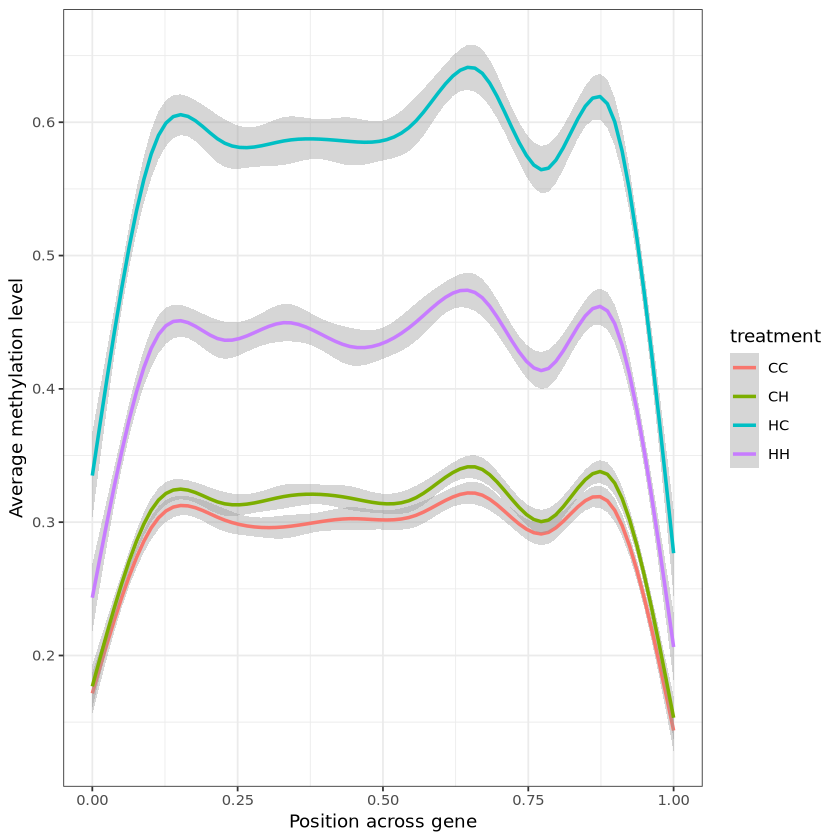

In [4]:
# Make the metaplot
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth() +
  labs(x = "Position across gene", y = "Average methylation level") +
  theme_bw()

want to show more noise...

In [ ]:
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.5) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = 'CpGs in all Genes') +
  theme_bw()

#### all genes and 1KB upstream/downstream

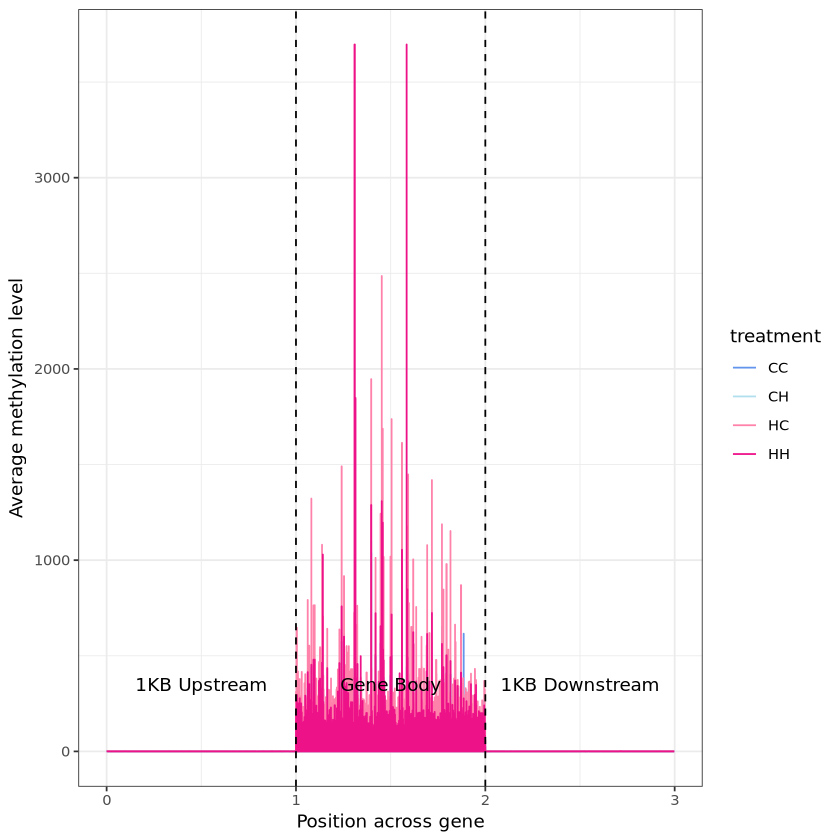

In [32]:
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_line() +
  labs(x = "Position across gene", y = "Average methylation level") +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  geom_vline(xintercept = c(1, 2), linetype = "dashed", color = "black") +
  annotate("text", x = 0.5, y = 3500, label = "1KB Upstream") +
  annotate("text", x = 1.5, y = 3500, label = "Gene Body") +
  annotate("text", x = 2.5, y = 3500, label = "1KB Downstream") +
theme_bw()

some of the methylation level is so high (>2000 seqs) that you can't see other stuff - although, doesn't appear to be a lot of methylation (if any at all) in the upstream and downstream of genes

applying a smoother to see if we see more patterns

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.1) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = 'CpGs withing DMGs') +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  geom_vline(xintercept = c(1, 2), linetype = "dashed", color = "black") +
  annotate("text", x = 0.5, y = 8, label = "1KB Upstream") +
  annotate("text", x = 1.5, y = 8, label = "Gene Body") +
  annotate("text", x = 2.5, y = 8, label = "1KB Downstream") +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


trying alternative methods for looking at this data because the above code takes forever and typically crashes the kernel

**downsample data** - get a random, representative sample of the larger df

In [29]:
mega_df_sampled <- mega_df %>%
# sample from the df, evenly across treatment combinations
  group_by(treatment, 
           # and evenly across the regions upstream, gene body, and downstream
           cpg_group = cut(cpg_scaled.pos, 
                           breaks = c(-Inf, 1, 2, Inf), 
                           labels = c("upstream", "gene_body", "downstream"))) %>%
# sample up to 1 million rows from each group, but if a group has fewer than 1 million rows,
# it will sample all rows from that group
  sample_n(size = min(1e6 / 3, n()), replace = TRUE)


In [ ]:
ggplot(mega_df_sampled, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.1) +
  labs(x = "Position across gene", y = "Average methylation level") +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  geom_vline(xintercept = c(1, 2), linetype = "dashed", color = "black") +
  annotate("text", x = 0.5, y = .8, label = "1KB Upstream") +
  annotate("text", x = 1.5, y = .8, label = "Gene Body") +
  annotate("text", x = 2.5, y = .8, label = "1KB Downstream") +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


same thing, but with `geom_line` instead of `geom_smooth`

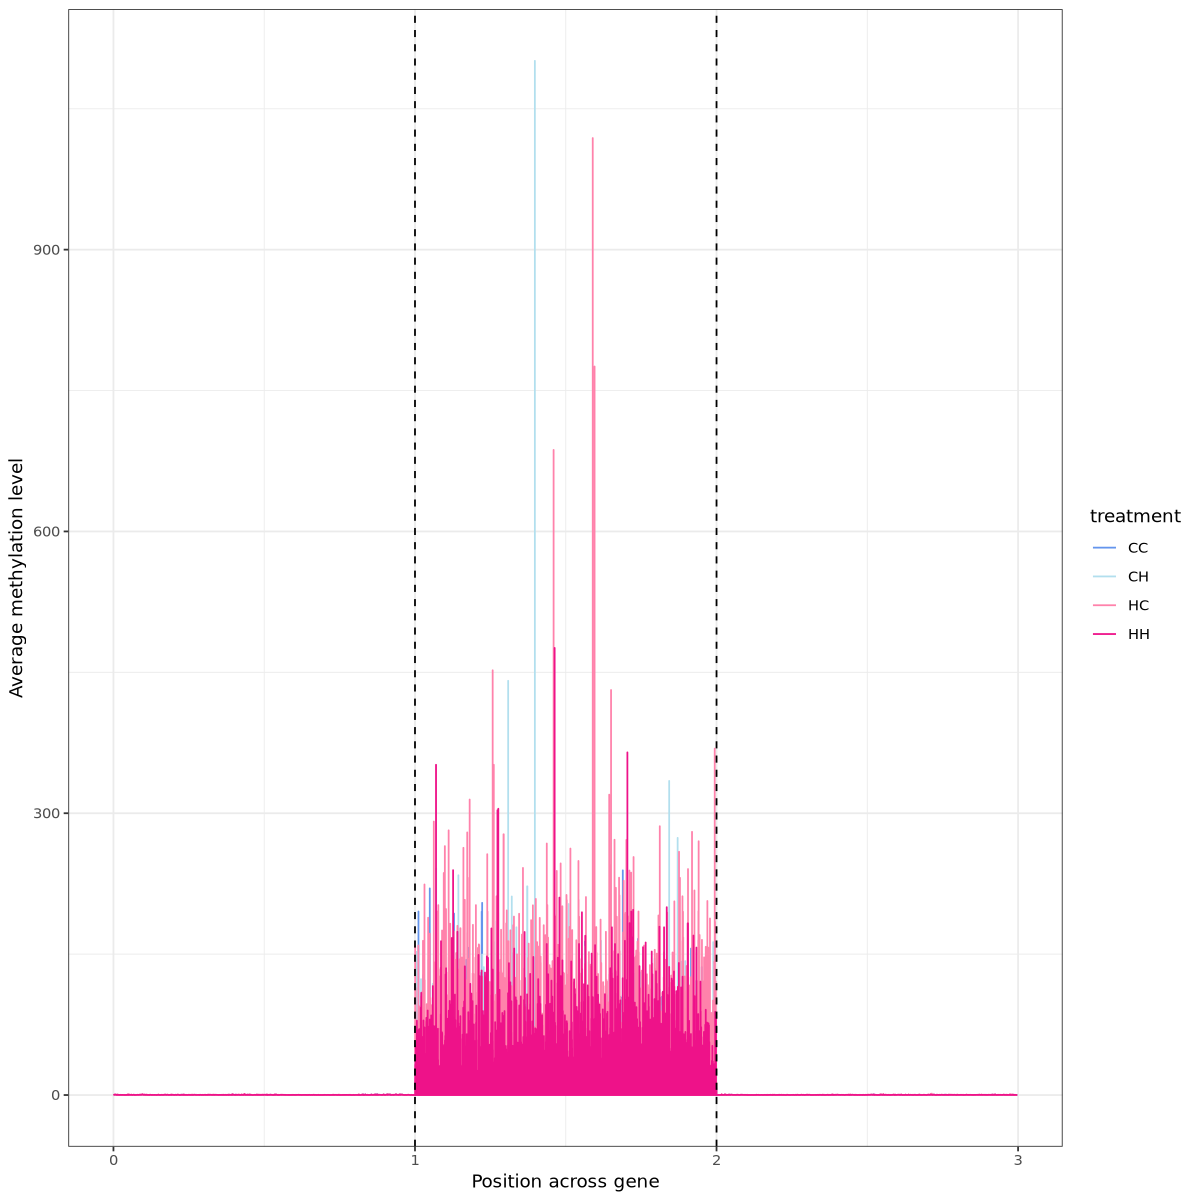

In [30]:
ggplot(mega_df_sampled, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_line() +
  labs(x = "Position across gene", y = "Average methylation level") +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  geom_vline(xintercept = c(1, 2), linetype = "dashed", color = "black") +
  theme_bw()

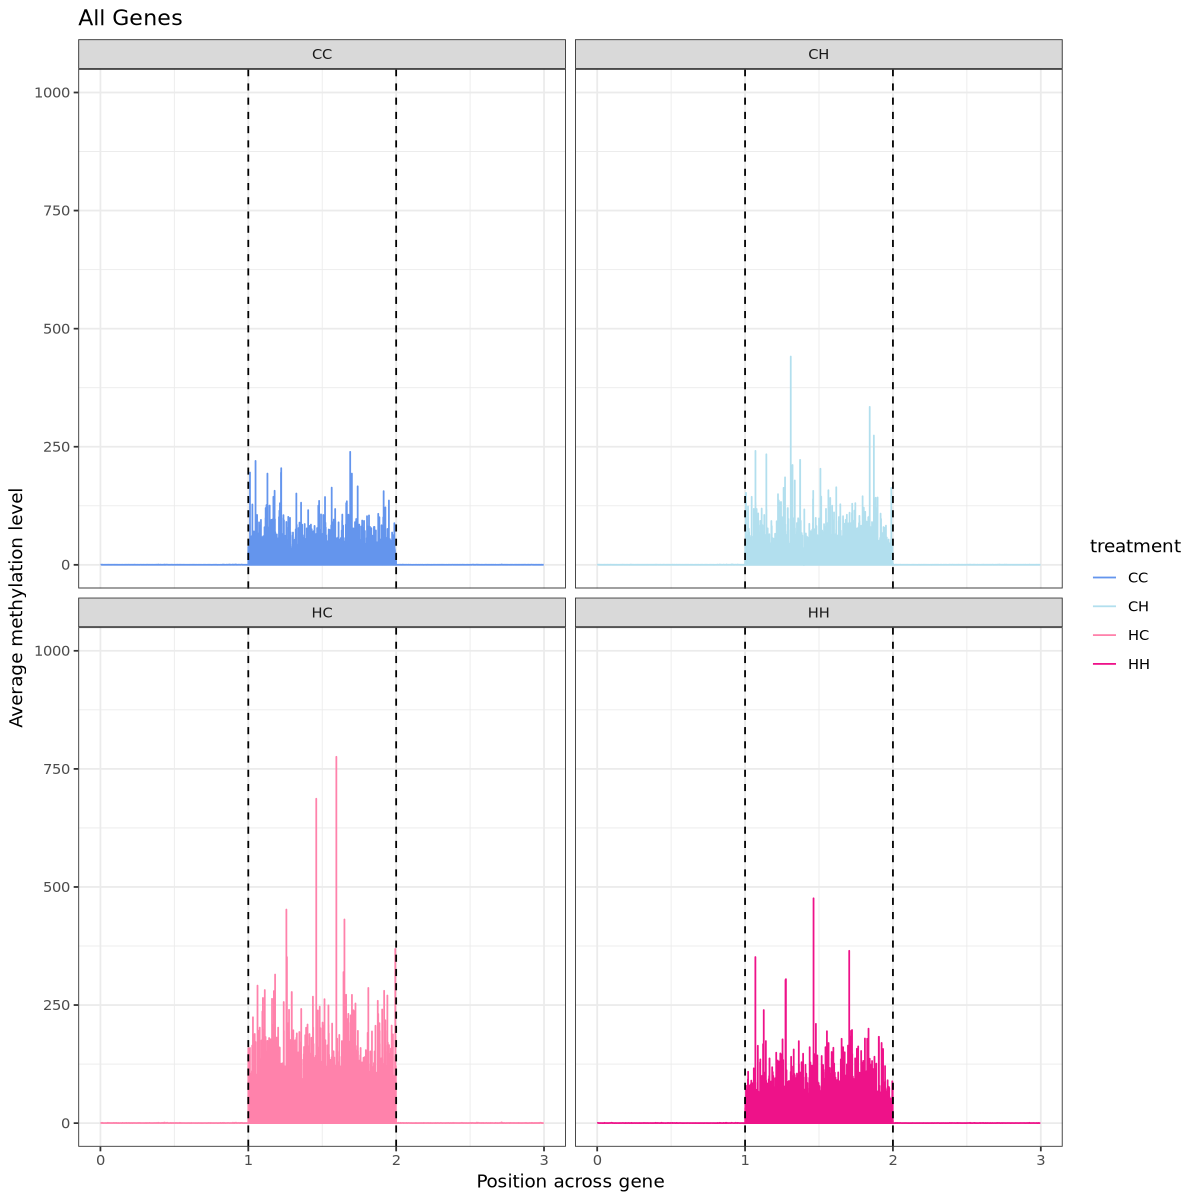

In [31]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(mega_df_sampled, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_line() +
facet_wrap(~treatment) +
ylim(0,1000) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = "All Genes") +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  geom_vline(xintercept = c(1, 2), linetype = "dashed", color = "black") +
  theme_bw()

**geom_hex** - for visualizing the density of points rather than individual points

In [ ]:
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_hex(bins = 50) +
  labs(x = "Position across gene", y = "Average methylation level",
       title = 'CpGs in all Genes') +
  theme_bw()

just want to make sure that the plots above are accurate in terms of methylion outside of gene bodies - is there really not any methylation?

In [27]:
# upstream
mega_df_sampled %>%
  filter(cpg_scaled.pos < 1) %>%
  group_by(treatment) %>%
  summarise(min = min(avg_methylation), max = max(avg_methylation))

# downstream
mega_df_sampled %>%
  filter(cpg_scaled.pos > 2) %>%
  group_by(treatment) %>%
  summarise(min = min(avg_methylation), max = max(avg_methylation))

treatment,min,max
<chr>,<dbl>,<dbl>
CC,0.02623705,0.4345934
CH,0.02029703,0.6954064
HC,0.05857843,0.5056075
HH,0.01098131,0.5189718


treatment,min,max
<chr>,<dbl>,<dbl>
CC,0.009923664,0.4204846
CH,0.024871795,0.2526961
HC,0.031273644,0.4794902
HH,0.037684729,0.5253874


okay so yea the average counts across the 5 replicates are so low, nothing ranges higher than 1 so that's accurate

### metaplot - *only* DMGs

read in csv that was created above, then seperate into treatment combos

In [ ]:
geneCpG <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/absPosition_geneCpG.csv')

In [14]:
CC_df <- geneCpG %>% 
  select(chromosome, start, stop, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("CC"))

HH_df <- geneCpG %>% 
  select(chromosome, start, stop, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("HH"))

CH_df <- geneCpG %>% 
  select(chromosome, start, stop, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("CH"))

HC_df <- geneCpG %>% 
  select(chromosome, start, stop, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("HC"))

In [30]:
# read in DMG bed file
dmg.bed <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/proportion_overlap/dmg_gff.bed', sep = '\t', header = FALSE)
colnames(dmg.bed) <- c('chromosome', 'start',  'stop')
head(dmg.bed)

,chromosome,start,stop
,<chr>,<int>,<int>
1,NC_035780.1,315522,340261
2,NC_035780.1,444907,453310
3,NC_035780.1,9011563,9043404
4,NC_035780.1,9288063,9301976
5,NC_035780.1,13324137,13332152
6,NC_035780.1,13591534,13596982


In [16]:
dim(dmg.bed)

[1] 217   3

In [17]:
head(HH_df)
dim(HH_df)

,chromosome,start,stop,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
351,NC_035780.1,13597,13599,13578,14594,19,1016,0.01870079,0,0,0,0,0
352,NC_035780.1,13651,13653,13578,14594,73,1016,0.07185039,0,0,0,0,0
353,NC_035780.1,13725,13727,13578,14594,147,1016,0.14468504,0,0,0,0,0
354,NC_035780.1,14144,14146,13578,14594,566,1016,0.55708661,0,0,0,0,0
355,NC_035780.1,14430,14432,13578,14594,852,1016,0.83858268,0,0,0,0,0
356,NC_035780.1,14453,14455,13578,14594,875,1016,0.86122047,0,0,0,0,0


[1] 8189462      13

In [37]:
subset_DMGs <- function(df1, df2) {
    # find the genomic range of the first df (the CpGs)
    df1_gr <- GRanges(seqnames = df1$chromosome, 
                  ranges = IRanges(start = df1$start, end = df1$stop))
    
    # find the genomic range of the second df (genomic feature)
    df2_gr <- GRanges(seqnames = df2$chromosome, 
                  ranges = IRanges(start = df2$start, end = df2$stop))

    # find overlaps
    overlaps <- findOverlaps(df1_gr, df2_gr, type = "within")

    # get the subset of cpgs within the genomic feature
    cpg_overlap <- df1[queryHits(overlaps), ]
    
    return(cpg_overlap)
    }

In [18]:
hh.dmg <- subset_DMGs(HH_df, dmg.bed)
cc.dmg <- subset_DMGs(CC_df, dmg.bed)
ch.dmg <- subset_DMGs(CH_df, dmg.bed)
hc.dmg <- subset_DMGs(HC_df, dmg.bed)

In [19]:
head(hh.dmg)

,chromosome,start,stop,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
7049,NC_035780.1,315523,315525,315522,340261,1,24739,4.042201e-05,0,0,0,0,0
7050,NC_035780.1,315549,315551,315522,340261,27,24739,1.091394e-03,0,0,0,0,0
7051,NC_035780.1,315563,315565,315522,340261,41,24739,1.657302e-03,0,0,0,0,0
7052,NC_035780.1,315567,315569,315522,340261,45,24739,1.818990e-03,0,0,0,0,0
7053,NC_035780.1,315618,315620,315522,340261,96,24739,3.880513e-03,0,0,0,0,0
7054,NC_035780.1,315688,315690,315522,340261,166,24739,6.710053e-03,0,0,0,0,0


In [20]:
ch_meta <- create_meta_df(ch.dmg, 'CH')
head(ch_meta)

cc_meta <- create_meta_df(cc.dmg, 'CC')
head(cc_meta)

hc_meta <- create_meta_df(hc.dmg, 'HC')
head(hc_meta)

hh_meta <- create_meta_df(hh.dmg, 'HH')
head(hh_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,CH,Control,Hypoxia
2.283418e-05,0,CH,Control,Hypoxia
3.695218e-05,0,CH,Control,Hypoxia
4.042201e-05,0,CH,Control,Hypoxia
4.436754e-05,0,CH,Control,Hypoxia
5.592137e-05,0,CH,Control,Hypoxia


cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,CC,Control,Control
2.283418e-05,0,CC,Control,Control
3.695218e-05,0,CC,Control,Control
4.042201e-05,0,CC,Control,Control
4.436754e-05,0,CC,Control,Control
5.592137e-05,0,CC,Control,Control


cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,HC,Control,Control
2.283418e-05,0,HC,Control,Control
3.695218e-05,0,HC,Control,Control
4.042201e-05,0,HC,Control,Control
4.436754e-05,0,HC,Control,Control
5.592137e-05,0,HC,Control,Control


cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,HH,Hypoxia,Hypoxia
2.283418e-05,0,HH,Hypoxia,Hypoxia
3.695218e-05,0,HH,Hypoxia,Hypoxia
4.042201e-05,0,HH,Hypoxia,Hypoxia
4.436754e-05,0,HH,Hypoxia,Hypoxia
5.592137e-05,0,HH,Hypoxia,Hypoxia


In [21]:
mega_df <- rbind(hh_meta, cc_meta, hc_meta, ch_meta)
dim(mega_df)
head(mega_df)

[1] 220624      5

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,HH,Hypoxia,Hypoxia
2.283418e-05,0,HH,Hypoxia,Hypoxia
3.695218e-05,0,HH,Hypoxia,Hypoxia
4.042201e-05,0,HH,Hypoxia,Hypoxia
4.436754e-05,0,HH,Hypoxia,Hypoxia
5.592137e-05,0,HH,Hypoxia,Hypoxia


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


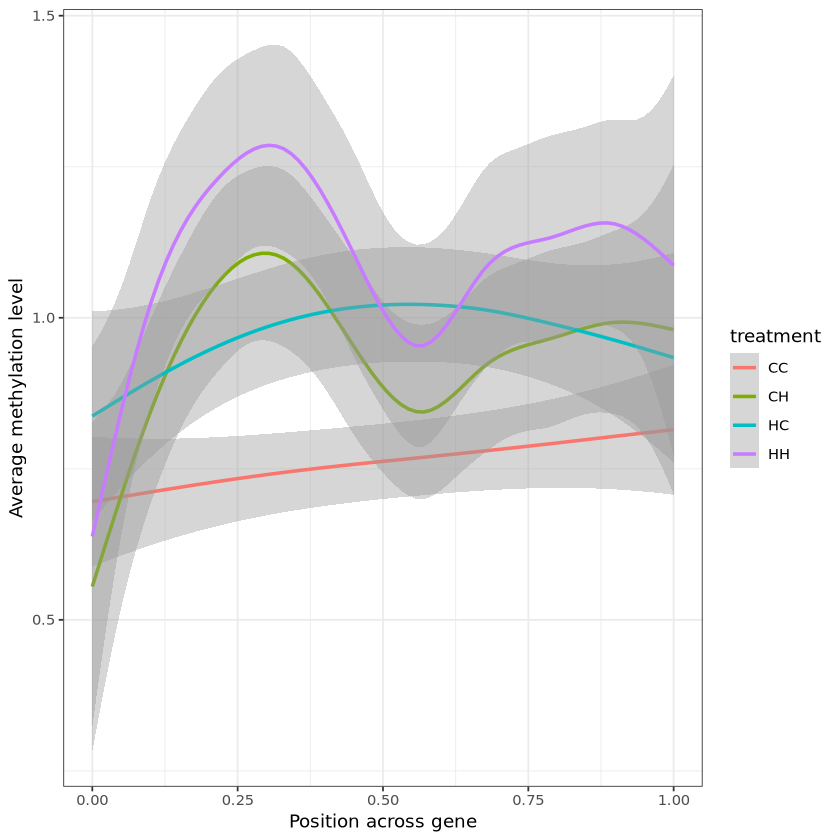

In [32]:
# Make the metaplot
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth() +
  labs(x = "Position across gene", y = "Average methylation level") +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


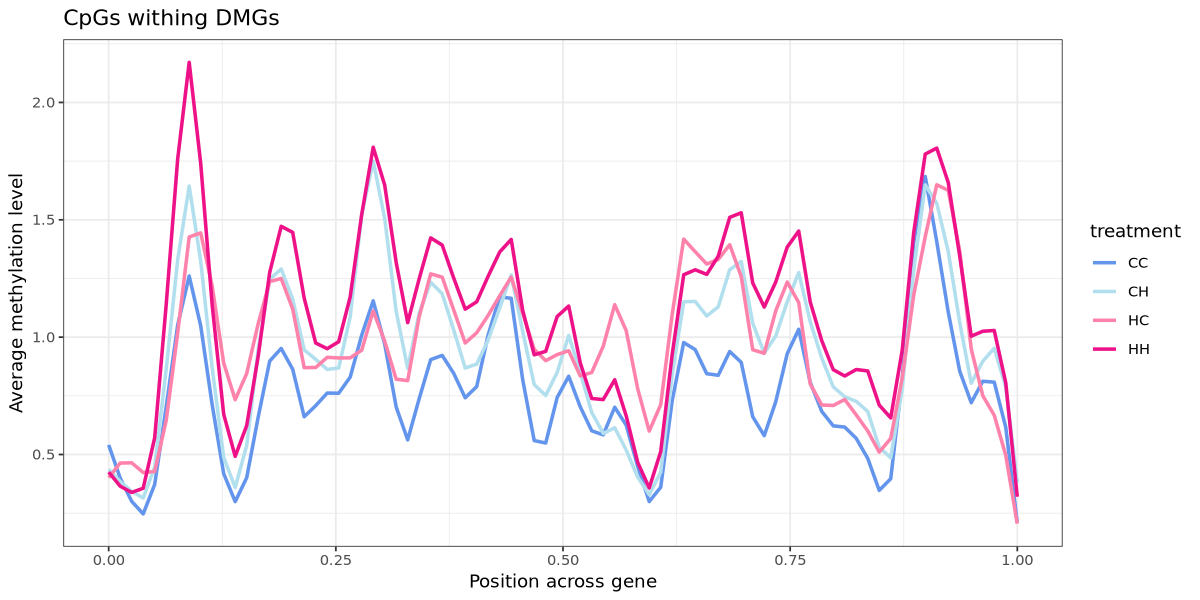

In [24]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.1) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = 'CpGs withing DMGs') +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


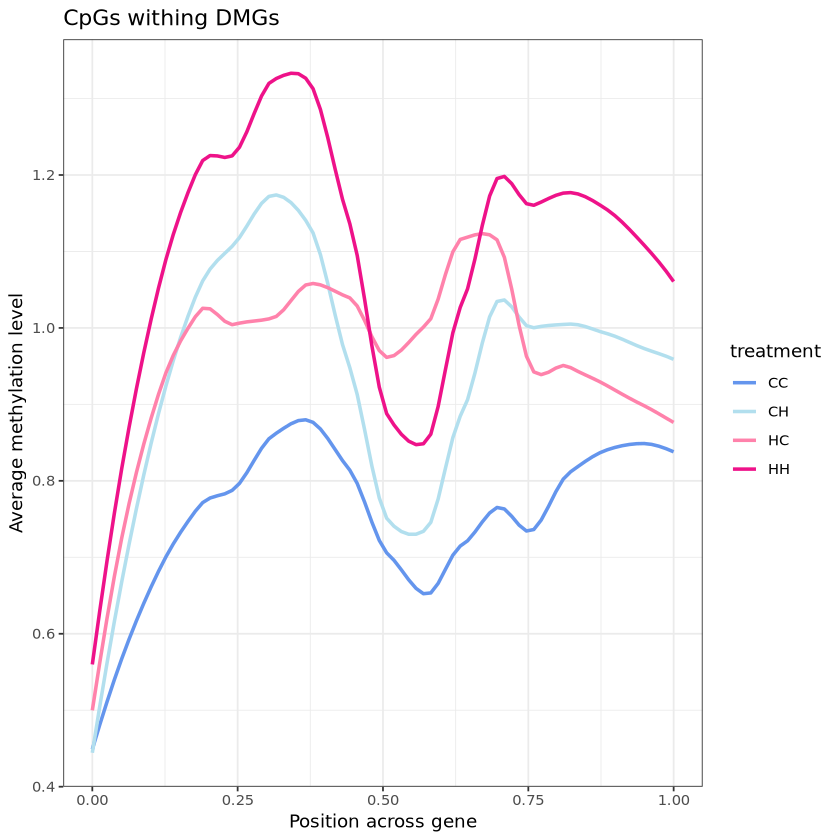

In [23]:
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.5) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = 'CpGs withing DMGs') +
scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  theme_bw()

## metaplots - only DMGs but with 1kb upstream and downstream

### 1a. find 1kb up- and down-stream

In [13]:
# calculate 1kb upstream and downstream
allGenes$kb_upstream <- allGenes$start - 1000
allGenes$kb_downstream <- allGenes$stop + 1000

## UPSTREAM OF GENE
kb_up <- allGenes %>%
select(chromosome, kb_upstream, start) %>%
mutate(region = 'upstream')
colnames(kb_up) <- c('chromosome', 'start', 'stop', 'region')

## DOWNSTREAM OF GENE
kb_down <- allGenes %>%
select(chromosome, stop, kb_downstream) %>%
mutate(region = 'downstream')
colnames(kb_down) <- c('chromosome', 'start', 'stop', 'region')

## BIND DFs
kb_updown <- rbind(kb_up, kb_down) 
# add length (which should all be 1000)
kb_updown$length <- kb_updown$stop - kb_updown$start

head(kb_updown)


,chromosome,start,stop,region,length
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,NC_035780.1,12578,13578,upstream,1000
2,NC_035780.1,27961,28961,upstream,1000
3,NC_035780.1,42111,43111,upstream,1000
4,NC_035780.1,84606,85606,upstream,1000
5,NC_035780.1,98840,99840,upstream,1000
6,NC_035780.1,107305,108305,upstream,1000


### 1b. calculate absolute position of CpG 
CpG start - feature start = absolute position

In [14]:
subset_CpGs <- function(df1, df2) {
    # find the genomic range of the first df (the CpGs)
    df1_gr <- GRanges(seqnames = df1$chromosome, 
                  ranges = IRanges(start = df1$start, end = df1$stop))
    
    # find the genomic range of the second df (genomic feature)
    df2_gr <- GRanges(seqnames = df2$chromosome, 
                  ranges = IRanges(start = df2$start, end = df2$stop))

    # find overlaps
    overlaps <- findOverlaps(df1_gr, df2_gr, type = "within")

    # get the subset of cpgs within the genomic feature
    cpg_overlap <- df1[queryHits(overlaps), ]
    
    # get the gene start and stop for each overlapping CpG
        region <- df2$region[subjectHits(overlaps)]
    gene_start <- df2$start[subjectHits(overlaps)]
    gene_stop <- df2$stop[subjectHits(overlaps)]
    
    # add the gene start and stop to the cpg_overlap dataframe
    cpg_overlap$region <- region
    cpg_overlap$gene_start <- gene_start
    cpg_overlap$gene_stop <- gene_stop
    
    return(cpg_overlap)
}

In [15]:
updown_CpG <- subset_CpGs(cpg, kb_updown)
head(updown_CpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC4,HC5,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
323,NC_035780.1,12583,12585,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
324,NC_035780.1,12595,12597,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
325,NC_035780.1,12633,12635,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
326,NC_035780.1,12685,12687,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
327,NC_035780.1,12757,12759,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578
328,NC_035780.1,12796,12798,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,upstream,12578,13578


In [16]:
# find the absolute position of the CpG within the feature
updown_CpG$cpg_abs.pos <- updown_CpG$start - updown_CpG$gene_start
head(updown_CpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC5,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
323,NC_035780.1,12583,12585,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,upstream,12578,13578,5
324,NC_035780.1,12595,12597,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,upstream,12578,13578,17
325,NC_035780.1,12633,12635,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,upstream,12578,13578,55
326,NC_035780.1,12685,12687,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,upstream,12578,13578,107
327,NC_035780.1,12757,12759,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,upstream,12578,13578,179
328,NC_035780.1,12796,12798,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,upstream,12578,13578,218


### 1c. calculate scaled position of CpG 
CpG abs.position / geneLength

In [17]:
# add gene length to df
updown_CpG$geneLength <- updown_CpG$gene_stop - updown_CpG$gene_start
head(updown_CpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH1,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
323,NC_035780.1,12583,12585,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,upstream,12578,13578,5,1000
324,NC_035780.1,12595,12597,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,upstream,12578,13578,17,1000
325,NC_035780.1,12633,12635,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,upstream,12578,13578,55,1000
326,NC_035780.1,12685,12687,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,upstream,12578,13578,107,1000
327,NC_035780.1,12757,12759,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,upstream,12578,13578,179,1000
328,NC_035780.1,12796,12798,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,upstream,12578,13578,218,1000


In [18]:
# scaled position
updown_CpG$cpg_scaled.pos <- updown_CpG$cpg_abs.pos / updown_CpG$geneLength
head(updown_CpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
323,NC_035780.1,12583,12585,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,upstream,12578,13578,5,1000,0.005
324,NC_035780.1,12595,12597,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,upstream,12578,13578,17,1000,0.017
325,NC_035780.1,12633,12635,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,upstream,12578,13578,55,1000,0.055
326,NC_035780.1,12685,12687,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,upstream,12578,13578,107,1000,0.107
327,NC_035780.1,12757,12759,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,upstream,12578,13578,179,1000,0.179
328,NC_035780.1,12796,12798,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,upstream,12578,13578,218,1000,0.218


In [23]:
huge_df <- rbind(geneCpG, updown_CpG)
head(huge_df)
tail(huge_df)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,19,1016,0.01870079
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,73,1016,0.07185039
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,147,1016,0.14468504
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,566,1016,0.55708661
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,852,1016,0.83858268
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,875,1016,0.86122047


,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14458121,NC_035789.1,32642810,32642812,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,742,1000,0.742
14458122,NC_035789.1,32642912,32642914,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,844,1000,0.844
14458123,NC_035789.1,32642929,32642931,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,861,1000,0.861
14458124,NC_035789.1,32642986,32642988,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,918,1000,0.918
14458125,NC_035789.1,32643015,32643017,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,947,1000,0.947
14458126,NC_035789.1,32643030,32643032,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,962,1000,0.962


In [26]:
huge_df <- huge_df %>%
  mutate(cpg_scaled.pos = case_when(
    region == "upstream" ~ cpg_scaled.pos,
    region == 'gene' ~ cpg_scaled.pos + 1,
    region == "downstream" ~ cpg_scaled.pos + 2,
    TRUE ~ cpg_scaled.pos
  ))

head(huge_df)
tail(huge_df)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,19,1016,1.018701
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,73,1016,1.071850
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,147,1016,1.144685
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,566,1016,1.557087
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,852,1016,1.838583
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,gene,13578,14594,875,1016,1.861220


,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH2,HH3,HH4,HH5,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14458121,NC_035789.1,32642810,32642812,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,742,1000,2.742
14458122,NC_035789.1,32642912,32642914,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,844,1000,2.844
14458123,NC_035789.1,32642929,32642931,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,861,1000,2.861
14458124,NC_035789.1,32642986,32642988,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,918,1000,2.918
14458125,NC_035789.1,32643015,32643017,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,947,1000,2.947
14458126,NC_035789.1,32643030,32643032,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,downstream,32642068,32643068,962,1000,2.962


In [35]:
CC_df <- huge_df %>% 
  select(chromosome, start, stop, region, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("CC"))

HH_df <- huge_df %>% 
  select(chromosome, start, stop, region, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("HH"))

CH_df <- huge_df %>% 
  select(chromosome, start, stop, region, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("CH"))

HC_df <- huge_df %>% 
  select(chromosome, start, stop, region, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("HC"))

In [34]:
# expanding dmg.bed to include 1kb upstream and downstream
dmg_bed_expanded <- data.frame(
  chromosome = dmg.bed$chromosome,
  start = dmg.bed$start - 1000,
  stop = dmg.bed$stop + 1000
)
head(dmg_bed_expanded)

,chromosome,start,stop
,<chr>,<dbl>,<dbl>
1,NC_035780.1,314522,341261
2,NC_035780.1,443907,454310
3,NC_035780.1,9010563,9044404
4,NC_035780.1,9287063,9302976
5,NC_035780.1,13323137,13333152
6,NC_035780.1,13590534,13597982


In [38]:
hh.dmg <- subset_DMGs(HH_df, dmg.bed)
cc.dmg <- subset_DMGs(CC_df, dmg.bed)
ch.dmg <- subset_DMGs(CH_df, dmg.bed)
hc.dmg <- subset_DMGs(HC_df, dmg.bed)

In [39]:
head(hh.dmg)

,chromosome,start,stop,region,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
7049,NC_035780.1,315523,315525,gene,315522,340261,1,24739,1.000040,0,0,0,0,0
7050,NC_035780.1,315549,315551,gene,315522,340261,27,24739,1.001091,0,0,0,0,0
7051,NC_035780.1,315563,315565,gene,315522,340261,41,24739,1.001657,0,0,0,0,0
7052,NC_035780.1,315567,315569,gene,315522,340261,45,24739,1.001819,0,0,0,0,0
7053,NC_035780.1,315618,315620,gene,315522,340261,96,24739,1.003881,0,0,0,0,0
7054,NC_035780.1,315688,315690,gene,315522,340261,166,24739,1.006710,0,0,0,0,0


In [40]:
create_meta_df <- function(df, treatment) {
  # Determine phase 1 and phase 2 based on treatment
  phase1 <- ifelse(grepl("C", treatment), "Control", "Hypoxia")
  phase2 <- ifelse(grepl("H$", treatment), "Hypoxia", "Control")
  
  # Create meta dataframe
  cols_to_select <- c("cpg_scaled.pos", grep(paste0("^", treatment), colnames(df), value = TRUE))
  
  meta_df <- df %>%
    select(all_of(cols_to_select)) %>%
    pivot_longer(cols = -cpg_scaled.pos, names_to = "sample", values_to = "methylation_level") %>%
    group_by(cpg_scaled.pos) %>%
    summarise(avg_methylation = mean(methylation_level)) %>%
    mutate(treatment = treatment,
           phase1 = phase1,
           phase2 = phase2)
  
  return(meta_df)
}

In [42]:
hh_meta <- create_meta_df(hh.dmg, 'HH')
cc_meta <- create_meta_df(cc.dmg, 'CC')
hc_meta <- create_meta_df(hc.dmg, 'HC')
ch_meta <- create_meta_df(ch.dmg, 'CH')

In [43]:
mega_df <- rbind(hh_meta, cc_meta, hc_meta, ch_meta)
dim(mega_df)
head(mega_df)

[1] 225912      5

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.001,0,HH,Hypoxia,Hypoxia
0.002,0,HH,Hypoxia,Hypoxia
0.003,0,HH,Hypoxia,Hypoxia
0.005,0,HH,Hypoxia,Hypoxia
0.006,0,HH,Hypoxia,Hypoxia
0.007,0,HH,Hypoxia,Hypoxia


`geom_smooth()` using formula = 'y ~ x'


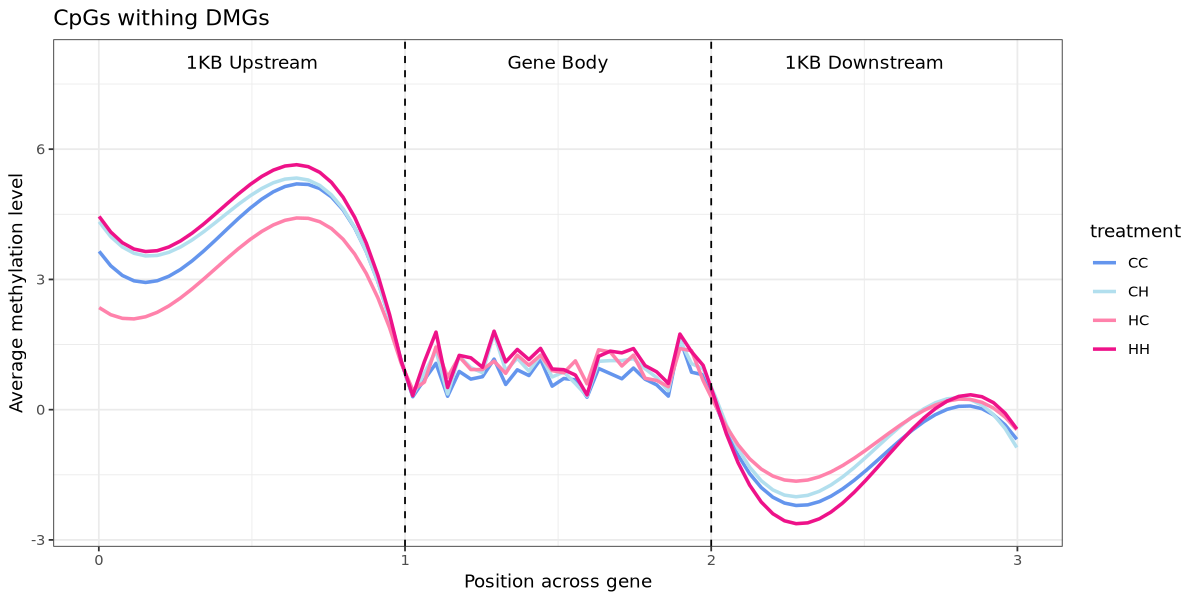

In [75]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.1) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = 'CpGs withing DMGs') +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  geom_vline(xintercept = c(1, 2), linetype = "dashed", color = "black") +
  annotate("text", x = 0.5, y = 8, label = "1KB Upstream") +
  annotate("text", x = 1.5, y = 8, label = "Gene Body") +
  annotate("text", x = 2.5, y = 8, label = "1KB Downstream") +
  theme_bw()

changes drastically when you change the span number .... and that's just a loess smoother, so not accurate in representing the actual data - see below

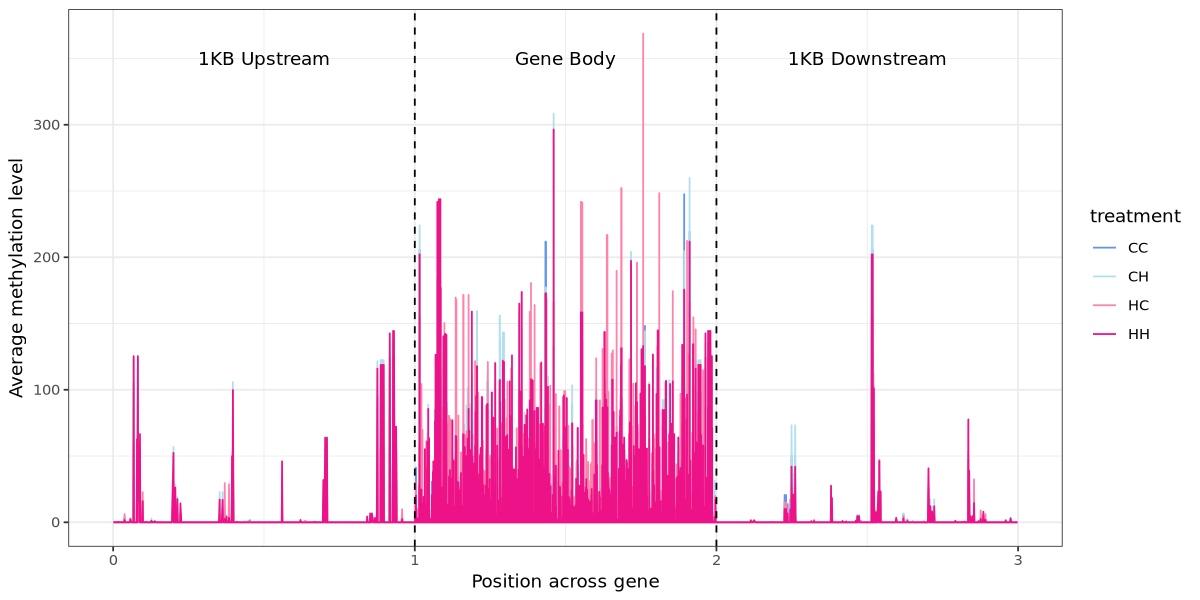

In [66]:
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_line() +
  labs(x = "Position across gene", y = "Average methylation level") +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  geom_vline(xintercept = c(1, 2), linetype = "dashed", color = "black") +
  annotate("text", x = 0.5, y = 350, label = "1KB Upstream") +
  annotate("text", x = 1.5, y = 350, label = "Gene Body") +
  annotate("text", x = 2.5, y = 350, label = "1KB Downstream") +
theme_bw()

# Other genomic features

## Exons